# Titanic Project

Thanks for ideas and codes to 
https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic
https://www.kaggle.com/mukultiwari/titanic-top-14-with-random-forest
http://trevorstephens.com/kaggle-titanic-tutorial/getting-started-with-r/
https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/

In [125]:
# Load packages
library('ggplot2') # visualization
library('Amelia') #visulaization
library('scales') # visualization
library('dplyr') # data manipulation
library('mice') # imputation
library('randomForest') # classification algorithm


In [126]:
train<-read.csv("Data/train.csv",stringsAsFactors = F)
test<-read.csv("Data/test.csv",stringsAsFactors = F)
full<-bind_rows(train,test)

In [127]:
cat('Example of Data')
head(full)

Example of Data

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


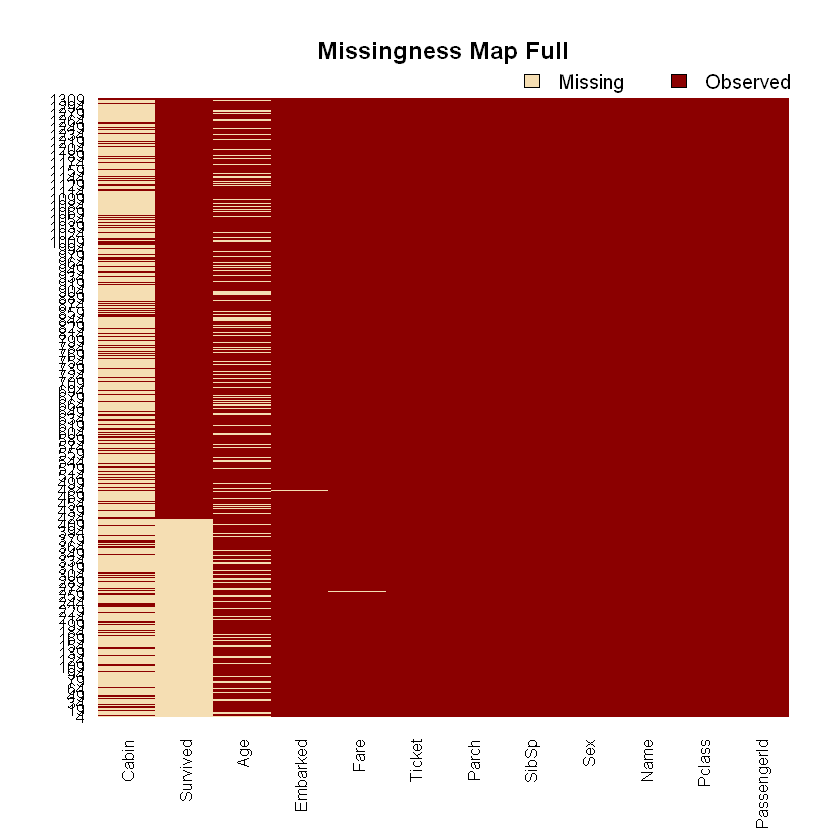

In [128]:
#replace missing values with NA
full[full == '']<-NA

par(mfrow=c(1,1))
missmap(full, main = "Missingness Map Full")

In [129]:
#substring different parts of name
full$Lname<-sub("([' A-Za-z0-9]+).*","\\1",full$Name)
full$Title<-gsub("(.*, )|(\\..*)", "", full$Name)
full$lenName <- round(sapply(full$Name,nchar)/10)
table(full$Title)


        Capt          Col          Don         Dona           Dr     Jonkheer 
           1            4            1            1            8            1 
        Lady        Major       Master         Miss         Mlle          Mme 
           1            2           61          260            2            1 
          Mr          Mrs           Ms          Rev          Sir the Countess 
         757          197            2            8            1            1 

In [130]:
# title with leader roles
leader_title <-c('Capt','Col','Dr','Major')
noble_title <-c('Jonkheer','Lady','Sir','the Countess','Rev')

# Also reassign mlle, ms, and mme accordingly
full$Title[full$Title == 'Mlle'] <- 'Miss' 
full$Title[full$Title == 'Ms']  <- 'Miss'
full$Title[full$Title %in% c('Mme', 'Dona')]  <- 'Mrs'
full$Title[full$Title == 'Don']  <- 'Mr'
full$Title[full$Title %in% leader_title]  <- 'Leader_Title'
full$Title[full$Title %in% noble_title]  <- 'Noble_Title'

table(full$Sex, full$Title)

        
         Leader_Title Master Miss  Mr Mrs Noble_Title
  female            1      0  264   0 199           2
  male             14     61    0 758   0          10

In [131]:
#prob of survied vs gender
table(train$Sex)
prop.table(table(train$Sex, train$Survived),margin=1)


female   male 
   314    577 

        
                 0         1
  female 0.2579618 0.7420382
  male   0.8110919 0.1889081

In [132]:
#Ticket length
full$ticketLen <- sapply(full$Ticket,nchar)
#First Character as ticket types
full$ticketType <- substring(full$Ticket,1,1)

cat('Ticket Length VS Survived')
prop.table(table(full$ticketLen,full$Survived),margin = 1)
cat('Ticket Type VS Survived')
prop.table(table(full$ticketType,full$Survived),margin = 1)

Ticket Length VS Survived

    
             0         1
  3  1.0000000 0.0000000
  4  0.6336634 0.3663366
  5  0.3816794 0.6183206
  6  0.6801909 0.3198091
  7  0.7037037 0.2962963
  8  0.4605263 0.5394737
  9  0.8076923 0.1923077
  10 0.6585366 0.3414634
  11 0.7500000 0.2500000
  12 0.6000000 0.4000000
  13 0.6000000 0.4000000
  15 0.6666667 0.3333333
  16 0.7272727 0.2727273
  17 0.5714286 0.4285714
  18 1.0000000 0.0000000

Ticket Type VS Survived

   
             0          1
  1 0.36986301 0.63013699
  2 0.53551913 0.46448087
  3 0.76079734 0.23920266
  4 0.80000000 0.20000000
  5 1.00000000 0.00000000
  6 0.83333333 0.16666667
  7 0.88888889 0.11111111
  8 1.00000000 0.00000000
  9 0.00000000 1.00000000
  A 0.93103448 0.06896552
  C 0.65957447 0.34042553
  F 0.42857143 0.57142857
  L 0.75000000 0.25000000
  P 0.35384615 0.64615385
  S 0.67692308 0.32307692
  W 0.84615385 0.15384615

Family Size VS Survival

       
          0   1
  large  52  10
  one   374 163
  small 123 169

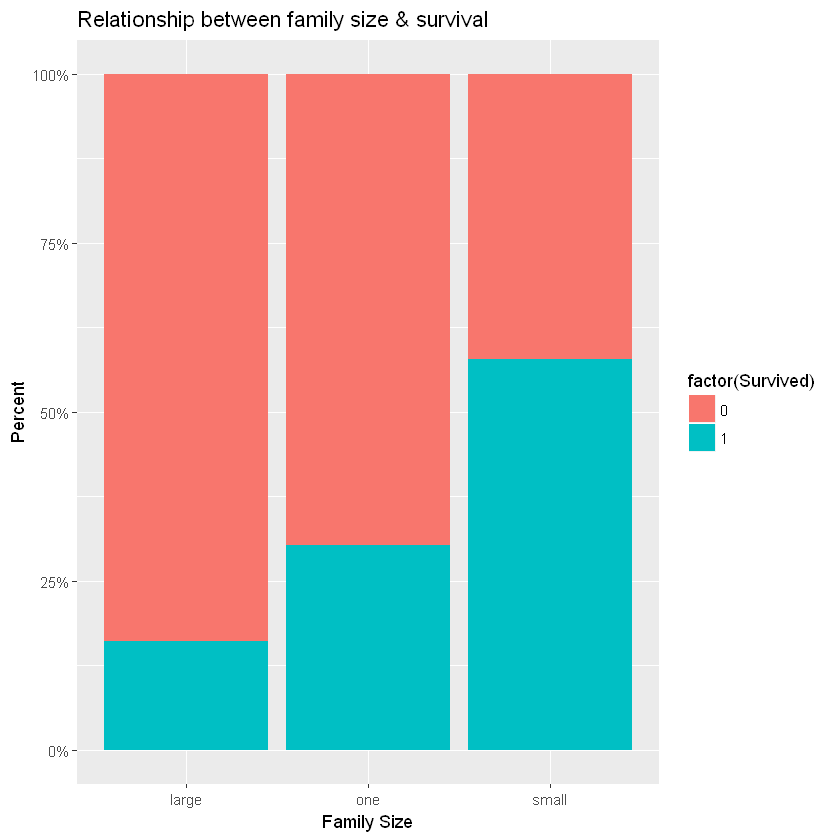

In [133]:
# Create a family size variable including the passenger themselves
full$Famsize <- full$SibSp + full$Parch + 1

# family size
full$FamsizeBin[full$Famsize == 1] <- 'one'
full$FamsizeBin[full$Famsize < 5 & full$Famsize > 1] <- 'small'
full$FamsizeBin[full$Famsize > 4] <- 'large'

# Use ggplot2 to visualize the relationship between family size & survival
ggplot(full[1:891,], aes(x = FamsizeBin, fill = factor(Survived))) +
  geom_bar(aes(y = (..count..)), stat='count', position='fill') +
  labs(x = 'Family Size') +
  scale_y_continuous(labels = percent) +
  labs(title="Relationship between family size & survival", y= 'Percent')

cat('Family Size VS Survival')
table(full$FamsizeBin,full$Survived)

In [134]:
#categorize if cabin available
full$hasCabin <- !is.na(full$Cabin)*1

embark_fare <-full %>% filter(!is.na(full$Embarked))
cat('Rows where Embarked missing')
head(full[is.na(full$Embarked),])


Rows where Embarked missing

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lname,Title,lenName,ticketLen,ticketType,Famsize,FamsizeBin,hasCabin
62,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,NA,Icard,Miss,2,6,1,1,one,TRUE
830,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,NA,Stone,Mrs,4,6,1,1,one,TRUE


Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."

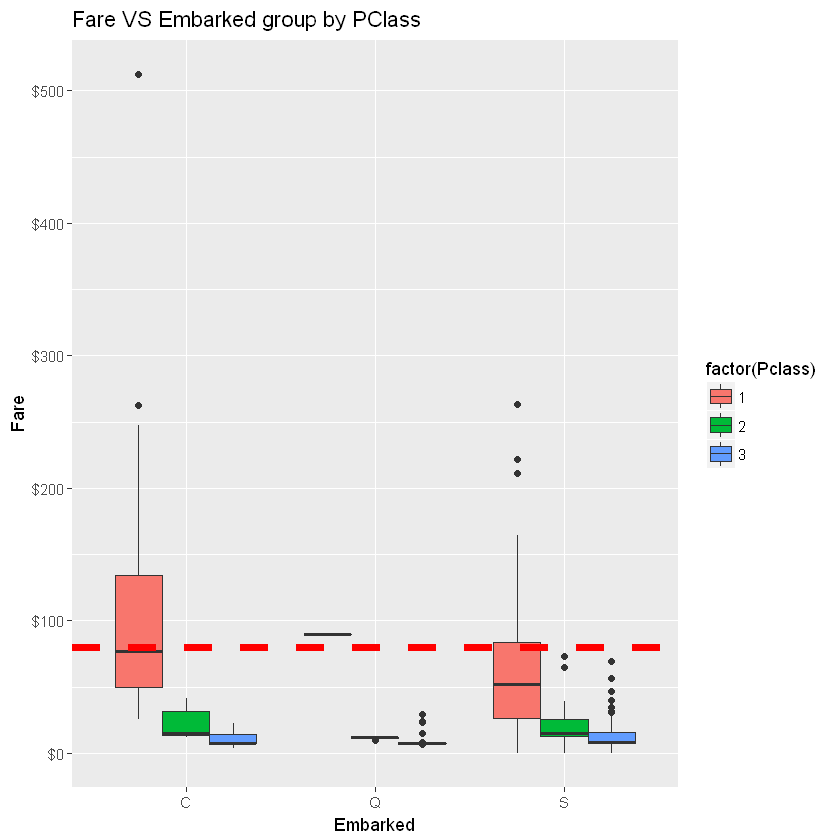

In [135]:

# Use ggplot2 to visualize embarkment, passenger class, & median fare
# warning 1 missing value on Fare
ggplot(embark_fare, aes(x = Embarked, y = Fare, fill = factor(Pclass))) +
  geom_boxplot() +
  geom_hline(aes(yintercept=80), 
             colour='red', linetype='dashed', lwd=2) +
  scale_y_continuous(labels=dollar_format()) +
  ggtitle("Fare VS Embarked group by PClass")

#from graph impute missing embark with C
full$Embarked[is.na(full$Embarked)] <- 'C'

Rows with missing fare

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lname,Title,lenName,ticketLen,ticketType,Famsize,FamsizeBin,hasCabin
1044,1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,NA,S,Storey,Mr,2,4,3,1,one,FALSE


Warning message:
"Removed 1 rows containing non-finite values (stat_density)."

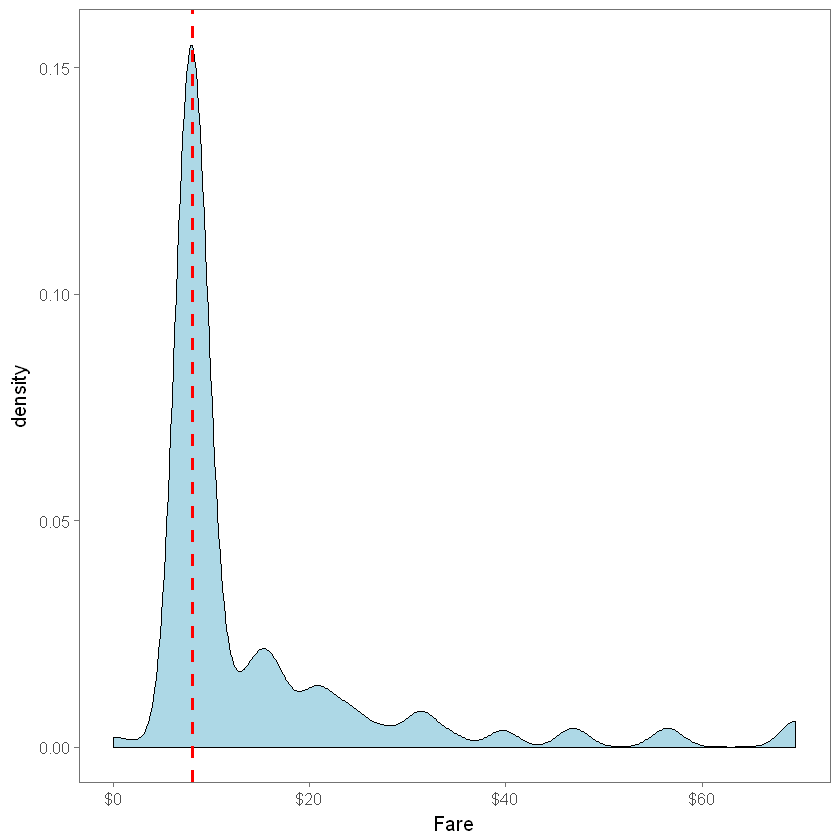

In [136]:
#impute missing Fare
cat('Rows with missing fare')
full[is.na(full$Fare),]

ggplot(full[full$Pclass == '3' & full$Embarked == 'S', ], 
       aes(x = Fare)) +
  geom_density(fill = 'light blue') + 
  geom_vline(aes(xintercept=median(Fare, na.rm=T)),
             colour='red', linetype='dashed', lwd=1) +
  scale_x_continuous(labels=dollar_format()) +
  theme_few()

# Replace missing fare value with median fare for class/embarkment
full$Fare[full$Pclass == '3' & full$Embarked == 'S' & is.na(full$Fare)] <- median(full[full$Pclass == '3' & full$Embarked == 'S', ]$Fare, na.rm = TRUE)

#categorize fare by bin
full$FareBin <- ceiling(full$Fare/20)

[1] 0.2009167


 iter imp variable
  1   1  Age
  1   2  Age
  1   3  Age
  1   4  Age
  1   5  Age
  2   1  Age
  2   2  Age
  2   3  Age
  2   4  Age
  2   5  Age
  3   1  Age
  3   2  Age
  3   3  Age
  3   4  Age
  3   5  Age
  4   1  Age
  4   2  Age
  4   3  Age
  4   4  Age
  4   5  Age
  5   1  Age
  5   2  Age
  5   3  Age
  5   4  Age
  5   5  Age


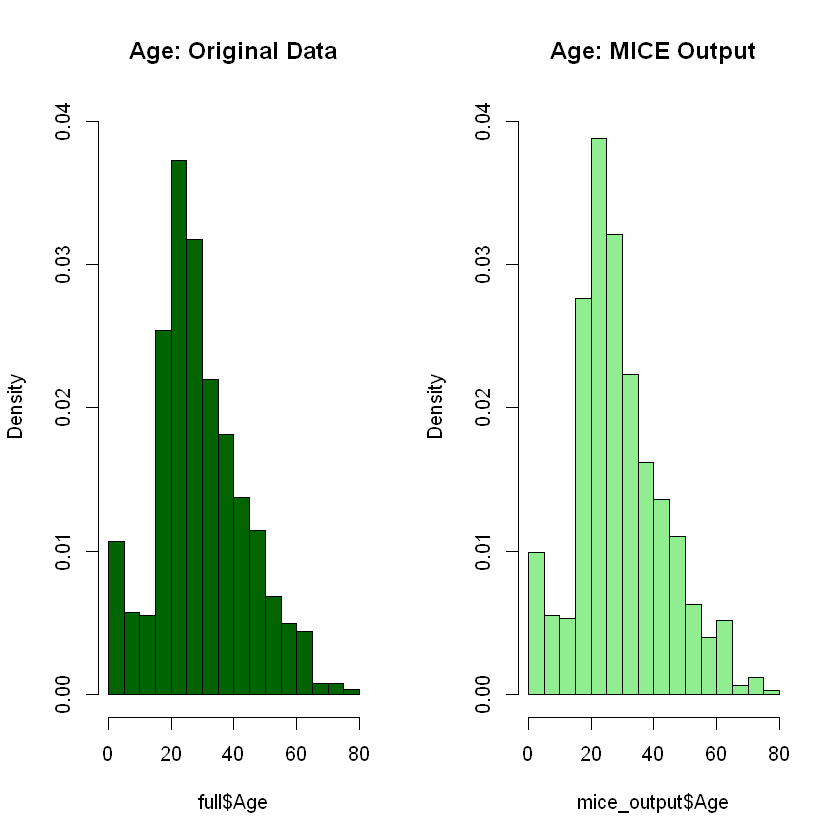

In [137]:
#impute age
mean(is.na(full$Age))

factor_vars <- c('PassengerId','Pclass','Sex','Embarked',
                 'Title','ticketLen','ticketType','FamsizeBin','FareBin','hasCabin')

full[factor_vars] <- lapply(full[factor_vars], function(x) as.factor(x))


# Perform mice imputation, excluding variables may not useful for age prediction:
mice_mod <- mice(full[, !names(full) %in% c('PassengerId','Name','Ticket','ticketLen','ticketType','Cabin','Lname','Fsize','Family','Survived')], method='rf') 
mice_output <- complete(mice_mod)

par(mfrow=c(1,2))
hist(full$Age, freq=F, main='Age: Original Data', 
     col='darkgreen', ylim=c(0,0.04))
hist(mice_output$Age, freq=F, main='Age: MICE Output', 
     col='lightgreen', ylim=c(0,0.04))

# Replace Age variable from the mice model.
full$Age <- mice_output$Age

In [138]:
#child, adult
full$Child<-0
full$Child[full$Age < 18] <- 1


,0,1,class.error
0,489,60,0.1092896
1,86,256,0.2514620


model2

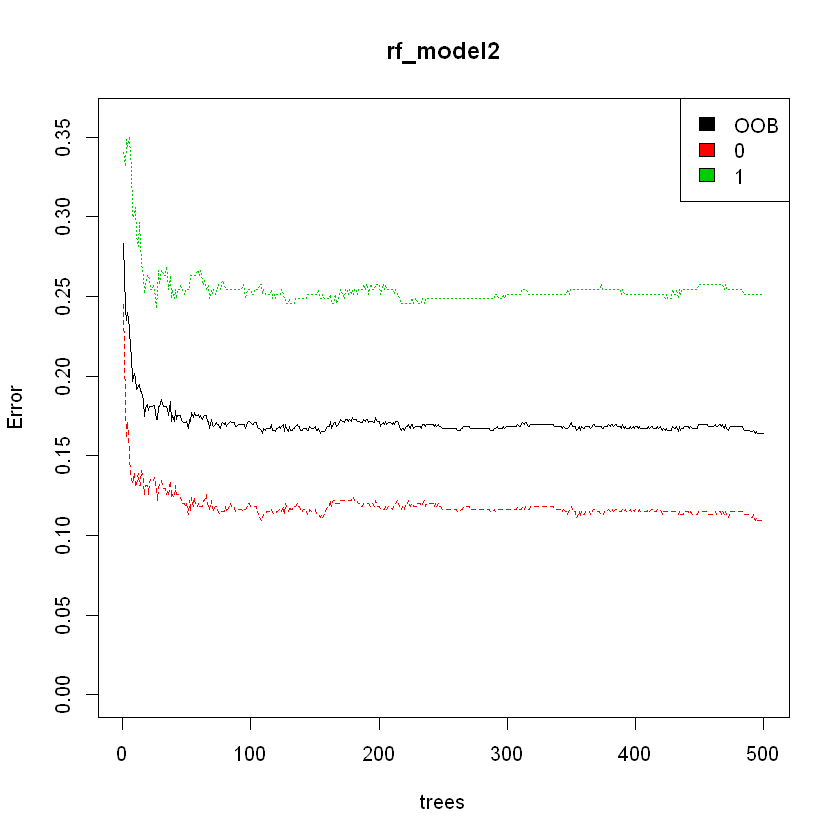

In [144]:
# Split the data back into a train set and a test set
train <- full[1:891,]
test <- full[892:1309,]


set.seed(754)

# Build the model (note: not all possible variables are used)
rf_model2 <- randomForest(factor(Survived) ~ Pclass + Sex + Age + SibSp + Parch + Embarked + Title + ticketLen +ticketType +
                           FamsizeBin + Fare + hasCabin + Child,
                         data = train)

rf_model2$confusion

cat('model2')
wrong_pred<-train[rf_model2$predicted != train$Survived,]

# Show model error
par(mfrow=c(1,1))
plot(rf_model2, ylim=c(0,0.36))
legend('topright', colnames(rf_model2$err.rate), col=1:3, fill=1:3)

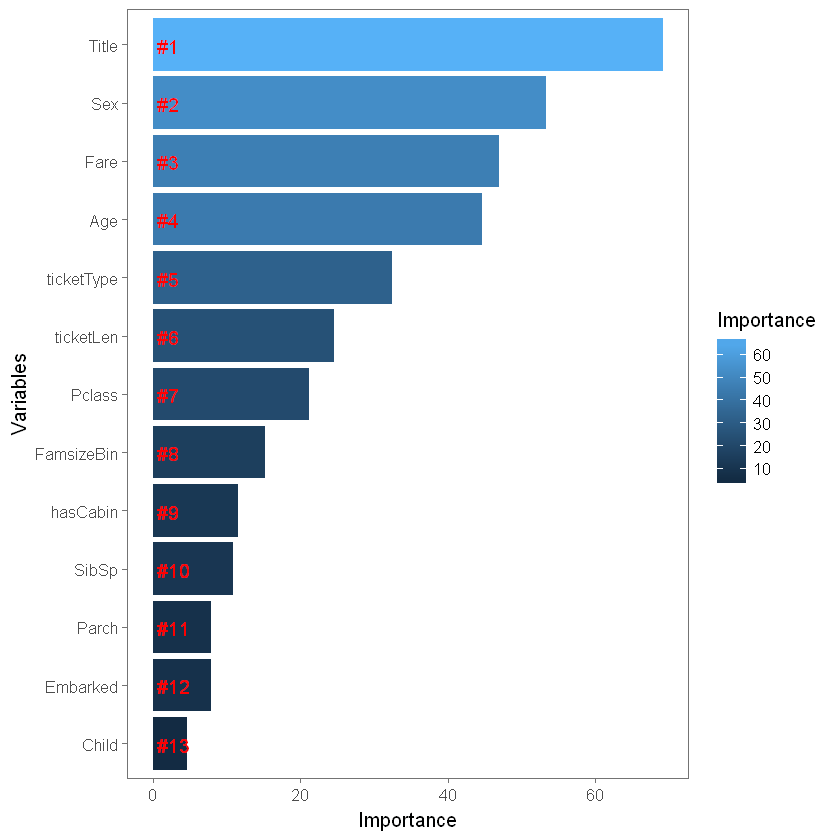

In [145]:
# Get importance
importance    <- importance(rf_model2)
varImportance <- data.frame(Variables = row.names(importance), 
                            Importance = round(importance[ ,'MeanDecreaseGini'],2))

# Create a rank variable based on importance
rankImportance <- varImportance %>%
  mutate(Rank = paste0('#',dense_rank(desc(Importance))))

# Use ggplot2 to visualize the relative importance of variables
ggplot(rankImportance, aes(x = reorder(Variables, Importance), 
                           y = Importance, fill = Importance)) +
  geom_bar(stat='identity') + 
  geom_text(aes(x = Variables, y = 0.5, label = Rank),
            hjust=0, vjust=0.55, size = 4, colour = 'red') +
  labs(x = 'Variables') +
  coord_flip() + 
  theme_few()


In [143]:
# Predict using the test set
prediction <- predict(rf_model2, test)

# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)
solution <- data.frame(PassengerID = test$PassengerId, Survived = prediction)

# Write the solution to file
write.csv(solution, file = 'Data/rf_mod_Solution3.csv', row.names = F)


In [146]:
#try logistic regression
model <- glm(Survived ~Pclass + Sex + Age + SibSp + Parch + Embarked + Title + ticketLen +ticketType +
                           FamsizeBin + Fare + hasCabin + Child
             ,family=binomial(link='logit'),data=train)

In [147]:
summary(model)


Call:
glm(formula = Survived ~ Pclass + Sex + Age + SibSp + Parch + 
    Embarked + Title + ticketLen + ticketType + FamsizeBin + 
    Fare + hasCabin + Child, family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7273  -0.5455  -0.2885   0.4620   3.0300  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -1.010e+00  2.125e+03   0.000 0.999621    
Pclass2           1.828e-01  6.888e-01   0.265 0.790693    
Pclass3          -9.847e-01  6.693e-01  -1.471 0.141236    
Sexmale          -1.684e+01  1.353e+03  -0.012 0.990069    
Age              -2.525e-02  1.059e-02  -2.384 0.017147 *  
SibSp            -2.713e-01  2.465e-01  -1.101 0.270977    
Parch            -2.497e-02  2.467e-01  -0.101 0.919358    
EmbarkedQ         4.401e-01  5.283e-01   0.833 0.404879    
EmbarkedS         1.078e-01  3.592e-01   0.300 0.764028    
TitleMaster       3.555e+00  9.874e-01   3.600 0.000318 

In [157]:
#should have cross validation to tune models but haven't done
fitted.results <- predict(model,newdata=test,type='response')
fitted.results <- ifelse(fitted.results > 0.5,1,0)
solution <- data.frame(PassengerID = test$PassengerId, Survived = fitted.results)
write.csv(solution, file = 'Data/logisticR_mod_Solution.csv', row.names = F)

Submitted the results
1) Random forest got ~ 79.425
2) Logistic Regression got ~ 78.468